# Validation gradient wind balance

In [1]:
import os
figsdir = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd-figs', 'manuscripts', '02_manuscript')

In [2]:
# %run '_setup.py'

import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import numpy as np
import xgcm
from oceanpy import gradient_wind_from_ssh, define_grid, horizontal_divergence, horizontal_strain, relative_vorticity

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

import cmocean as cmo
import string

In [3]:
fs_small = 18
fs_large = 20
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
plt.rc('text', usetex=False)

savefig = False

In [4]:
database = '/g/data/ik11/databases/cosima_master.db'
session = cc.database.create_session(db=database)

expt = '01deg_jra55v140_iaf'

client = Client(n_workers=8, memory_limit='180GB')

## Load data

In [5]:
# data output frequency
freq = '1 daily'

# time limits of dataset
start, end = '1997-04-01', '1997-04-30'
time_lim = slice(start, end)

# location limits of dataset
lon_lim = slice(-224.2, -212.5) #slice(-223, -213)
lat_lim = slice(-53.5, -47.5) #slice(-52.98, -48)

In [6]:
# load variables 
sl = cc.querying.getvar(expt=expt, variable='sea_level', session=session, frequency=freq, start_time=start, end_time=end)
u = cc.querying.getvar(expt=expt, variable='u', session=session, frequency=freq, start_time=start, end_time=end)
v = cc.querying.getvar(expt=expt, variable='v', session=session, frequency=freq, start_time=start, end_time=end)
wt = cc.querying.getvar(expt=expt, variable='wt', session=session, frequency=freq, start_time=start, end_time=end)

# load coordinates
dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)
dzt = cc.querying.getvar(expt=expt, variable='dzt', session=session, frequency='1 monthly', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

area_t = cc.querying.getvar(expt=expt, variable='area_t', session=session, frequency='static', n=1)
area_u = cc.querying.getvar(expt=expt, variable='area_u', session=session, frequency='static', n=1)

## Select regional data

In [7]:
flex_period = slice('1997-04-10', '1997-04-25')

# select spatial area
sl_lim = sl.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
u_lim = u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
v_lim = v.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
wt_lim = wt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
# dzt_lim = dzt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

areat_lim = area_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
areau_lim = area_u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)


## Define Grid

### Calculate finite differences with package `xgcm`
The way `xgcm` works is that we first create a `grid` object that has all the information regarding our staggered grid. For our case, `grid` needs to know the location of the `xt_ocean`, `xu_ocean` points (and same for y) and their relative orientation to one another, i.e., that `xu_ocean` is shifted to the right of `xt_ocean` by $\frac{1}{2}$ grid-cell.

In [8]:
ds = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim, areat_lim, areau_lim])
ds = xr.merge([ds, sl_lim.sel(time=flex_period), u_lim.sel(time=flex_period), v_lim.sel(time=flex_period)])

ds = ds.assign_coords(
    xt_ocean=(((ds.xt_ocean + 180) % 360) - 180), 
    yt_ocean=ds.yt_ocean)

# ds = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])
# ds = xr.merge([ds, u_lim.sel(time=flex_period), v_lim.sel(time=flex_period)])

coords = {'xt_ocean': None, 'yt_ocean': None, 'xu_ocean': -0.5, 'yu_ocean': -0.5}
distances=('dxt', 'dyt', 'dxu', 'dyu')
areas=('area_u', 'area_t')
dims=('X', 'Y')

grid = define_grid(ds, dims, coords, distances, areas, periodic=False)
grid


<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> left
  * left     xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> inner
  * inner    yu_ocean --> center

## Local time derivative flow speed

In [9]:
# dt = np.gradient(ds.time).shape
# V = np.sqrt(ds.u**2 + ds.v**2)
# dVdt = V.sel(st_ocean=0, method='nearest').chunk({"time": 2}).differentiate('time')
# Vadd = dVdt * dt
# Vadd.sum('time').plot(size=8)

# Vadd.sum().plot(ax=ax)
# ds.v.sel(st_ocean=0, method='nearest').chunk({"time": 2}).differentiate('time').mean('time').plot(ax=ax[1])

## Gradient wind, geostrophic and ageostrophic velocities

In [10]:
flex_period = slice('1997-04-10', '1997-04-25')

# Calculate flow speed at the surface
sl = sl_lim.sel(time=flex_period)
u = u_lim.sel(time=flex_period)
v = v_lim.sel(time=flex_period)
V = np.sqrt(u**2 + v**2)
V.name, u.name, v.name = 'Vtot', 'utot', 'vtot'

# Calculate gradient wind and geostrophic velocities from sea level
UTM54 = 'EPSG:32754'
gw = gradient_wind_from_ssh(sl, transform=UTM54, 
                            dimensions=('time', 'yt_ocean', 'xt_ocean'))

# Smoothing (!!!!)
gw_smooth = gradient_wind_from_ssh(sl, transform=UTM54, 
                                   dimensions=('time', 'yt_ocean', 'xt_ocean'), 
                                   smooth={'boxcar': 3})


### Difference between smoothing in gradient wind calculation and not

In [11]:
# (gw.Vgw - gw_smooth.Vgw).mean('time').plot(size=8)

In [12]:
# Merge all velocities in 1 dataset and make xgcm grid
ds = xr.merge([sl, dxt_lim, dyt_lim, dxu_lim, dyu_lim, V, u, v, gw_smooth])

ds = ds.assign_coords(xt_ocean=((ds.xt_ocean + 180) % 360) - 180)

ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds)

In [13]:
# Interpolate total surface velocity to t-cells
ut = grid.interp(grid.interp(ds.utot, 'Y', boundary='extend'), 'X', boundary='extend')
vt = grid.interp(grid.interp(ds.vtot, 'Y', boundary='extend'), 'X', boundary='extend')
Vt = np.sqrt(ut**2 + vt**2)
ut.name, vt.name, Vt.name = 'utott', 'vtott', 'Vtott'

# Calculate velocity difference between gradient wind/ geostrophic and total velocities
dug, dvg = ut.isel(st_ocean=30) - ds.ug, vt.isel(st_ocean=30) - ds.vg
dVg = np.sqrt(dug**2 + dvg**2)
dug.name, dvg.name, dVg.name = 'dug', 'dvg', 'dVg'

dugw, dvgw = ut.isel(st_ocean=0) - ds.ugw, vt.isel(st_ocean=0) - ds.vgw
dVgw = np.sqrt(dugw**2 + dvgw**2)
dugw.name, dvgw.name, dVgw.name = 'dugw', 'dvgw', 'dVgw'

gw = xr.merge([ds, ut, vt, Vt, dug, dvg, dVg, dugw, dvgw, dVgw])
gw = gw.assign_coords(xt_ocean=((gw.xt_ocean + 180) % 360) - 180)

## Validate gradient wind velocity

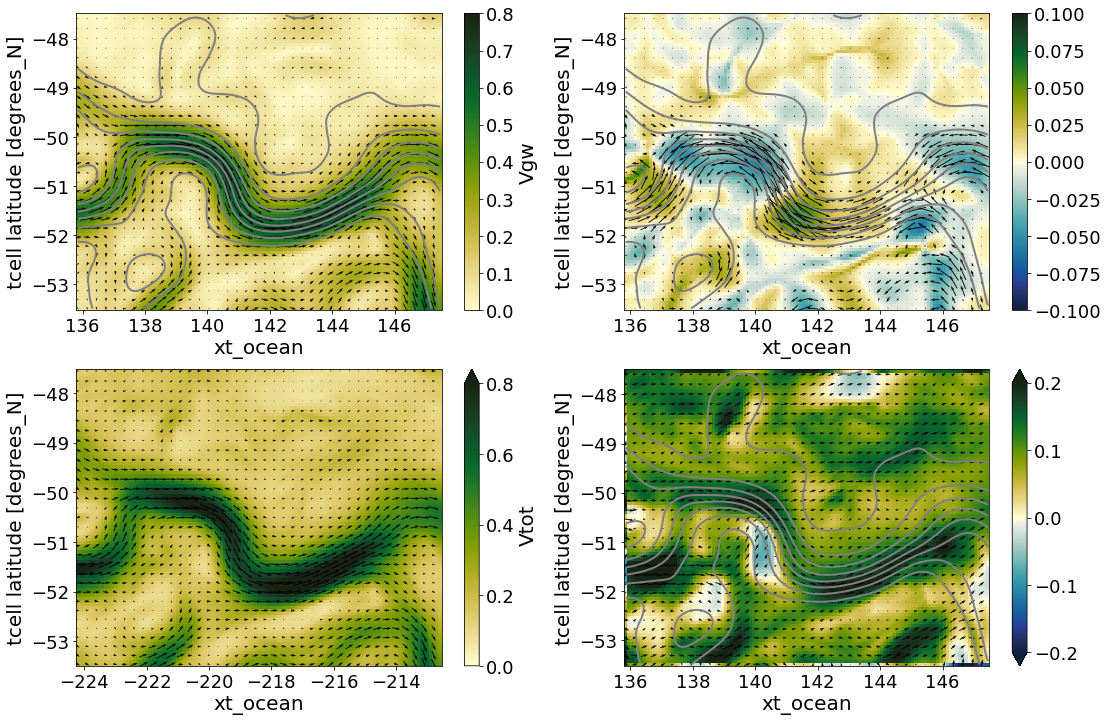

In [14]:
nrows, ncols = 2, 2
slc = xt_ocean=slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,12))

# Plot gradient wind speed
gw.Vgw.mean('time').plot(ax=ax[0, 0], cmap=cmo.cm.speed, vmin=0, vmax=0.8)
gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0, 0], x='xt_ocean', y='yt_ocean', u='ugw', v='vgw')

# Plot Rossby number (ratio ageostrophic over gradient wind speed)
((gw.Vgw - gw.Vg) / gw.Vgw).mean('time').plot(ax=ax[0, 1], cmap=cmo.cm.delta, vmin=-0.1, vmax=0.1)
gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0, 1], x='xt_ocean', y='yt_ocean', u='uag', v='vag')

# Plot total surface flow speed
gw.Vtot.isel(st_ocean=0).mean('time').plot(ax=ax[1, 0], cmap=cmo.cm.speed, vmin=0, vmax=0.8)
gw.isel(st_ocean=0).mean('time').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[1, 0], x='xu_ocean', y='yu_ocean', u='utot', v='vtot')

# Plot difference between total and gradient wind flow speed
(gw.Vtott.isel(st_ocean=0) - gw.Vgw).mean('time').plot(ax=ax[1, 1], cmap=cmo.cm.delta, vmin=-0.2, vmax=0.2)
gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1, 1], x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', color='k')


# Plot sea level contours
sl_contours = np.linspace(-0.7, 0, 8)
for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    cont = gw.sea_level.mean('time').plot.contour(
            ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')

In [15]:
plt.rcParams.update(plt.rcParamsDefault)

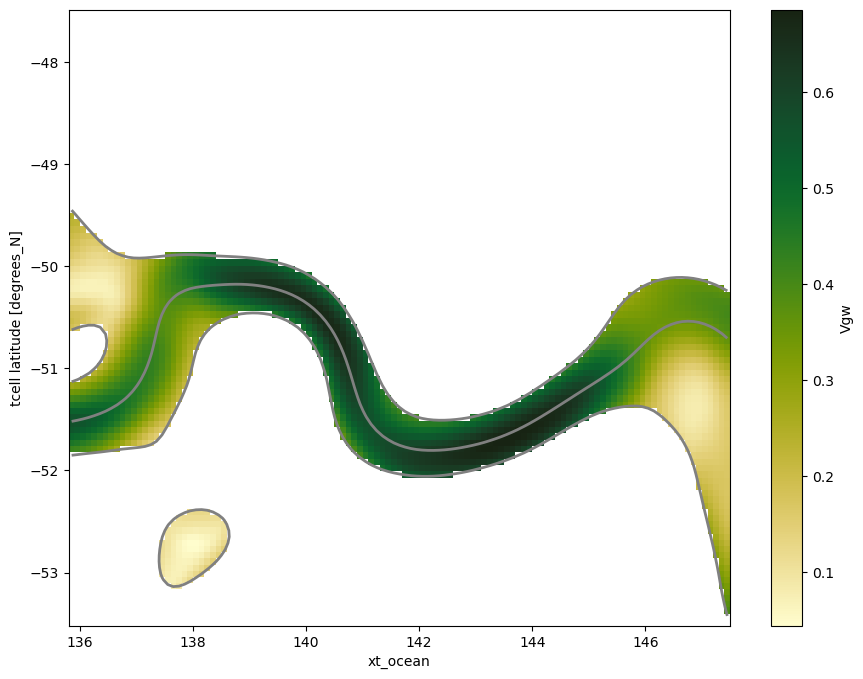

In [16]:
core_contour = -0.4
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
gwmean = gw.mean('time')
gwmean.Vgw.where(
    (gwmean.sea_level > sl_contours[0]) & 
    (gwmean.sea_level < sl_contours[-1])).plot(size=8, cmap=cmo.cm.speed)
cont = gw.sea_level.mean('time').plot.contour(
    levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')

## Horizontal divergence from gradient wind balance at sea level

$$ \nabla_h \times {\bf u} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} $$

Gradient wind balance
$$\kappa{|\textbf{u}|}^2 + f|\textbf{u}| = g{\bf \hat{k}} \times \nabla \eta$$

Gradient wind speed is the combination of geostrophic and ageostrophic velocities

$$\textbf{u} = {\bf u_g}+ {\bf u_a}$$

Divergence in the flow field is due to ageostrophy velocities (geostrophic flow is divergence free)

$$\frac{\partial u_a}{\partial x} + \frac{\partial v_a}{\partial y}$$

In [17]:
ds = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim, areat_lim, areau_lim])
ds = xr.merge([ds, sl_lim.sel(time=flex_period), u_lim.sel(time=flex_period), v_lim.sel(time=flex_period)])

ds = ds.assign_coords(xt_ocean=(((ds.xt_ocean + 180) % 360) - 180), xu_ocean=(((ds.xu_ocean + 180) % 360) - 180))

In [18]:
ds_gw = gw.get(['sea_level', 'uag', 'vag', 'dxu', 'dyu'])
ds_gw.coords['xt_ocean'].attrs.update(axis='X')
ds_gw.coords['yt_ocean'].attrs.update(axis='Y')

ds_gw = ds_gw.assign_coords(xt_ocean=((ds_gw.xt_ocean + 180) % 360) - 180)

In [19]:
div_u = horizontal_divergence(ds, grid, delta_names=('dxt', 'dyt'))
div_u = div_u.assign_coords(xu_ocean=(((ds.xu_ocean + 180) % 360) - 180))
div_u.name = 'divu'
div_u.attrs['long_name'] = r"$\nabla_h \cdot u$"
ds = xr.merge([ds, div_u])

div_ut = grid.interp(grid.interp(div_u, 'Y', boundary='extend'), 'X', boundary='extend')
div_ut.name = 'divu'
div_ut.attrs['long_name'] = r'$\nabla_h \cdot u$'

div_u_gw = horizontal_divergence(ds_gw, grid, vel_names=('uag', 'vag'), delta_names=('dxu', 'dyu'))
div_u_gw.name = 'divua'
div_u_gw.attrs['long_name'] = r'$\nabla_h \cdot u_a$'
ds_gw = xr.merge([ds_gw, div_u_gw, div_ut])

In [20]:
# fig, ax = plt.subplots(figsize=(16, 16))

# for depth in [0, 30, 200]:
#     sel = gw_core.sel(st_ocean=depth, method='nearest')
#     sel.plot.scatter(ax=ax, x='divua', y='divu', s=10, label=sel.st_ocean.values)
# x= np.linspace(-4e-6, 4e-6)
# ax.plot(x, x, '--', color='k', lw=0.5)
# ax.set_xlim([-1.5e-6, 1.5e-6])
# ax.set_ylim([-1.5e-6, 1.5e-6])
# fig.legend()

## Manuscript figure

In [21]:
def linear_fit(x, y):

    x = np.ma.masked_invalid(x).flatten()
    y = np.ma.masked_invalid(y).flatten()

    mask = x.mask | y.mask
    pf = np.polyfit(x[~mask],y[~mask], 1)
    f = np.poly1d(pf)

    return x, f(x)

def Rsquared(var_x, var_y, mask=None):
    
    mask_x, mask_y = np.ma.masked_invalid(var_x).mask, np.ma.masked_invalid(var_y).mask
    mask = np.zeros(mask_x.shape, dtype=bool) if mask is None else mask
    mask = mask | mask_x | mask_y

    coef = np.polyfit(var_x[~mask], var_y[~mask], 1)
    f = np.poly1d(coef)
    
    # coefficient of determination
    SSres = np.sum((var_y[~mask] - f(var_x)[~mask])**2)
    SStot = np.sum((var_y[~mask] - np.nanmean(var_y[~mask]))**2)
    
    R2 = 1 - (SSres/SStot)
    
    return R2, f

In [30]:
# plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm'})
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})


Text(0, 0.5, '')

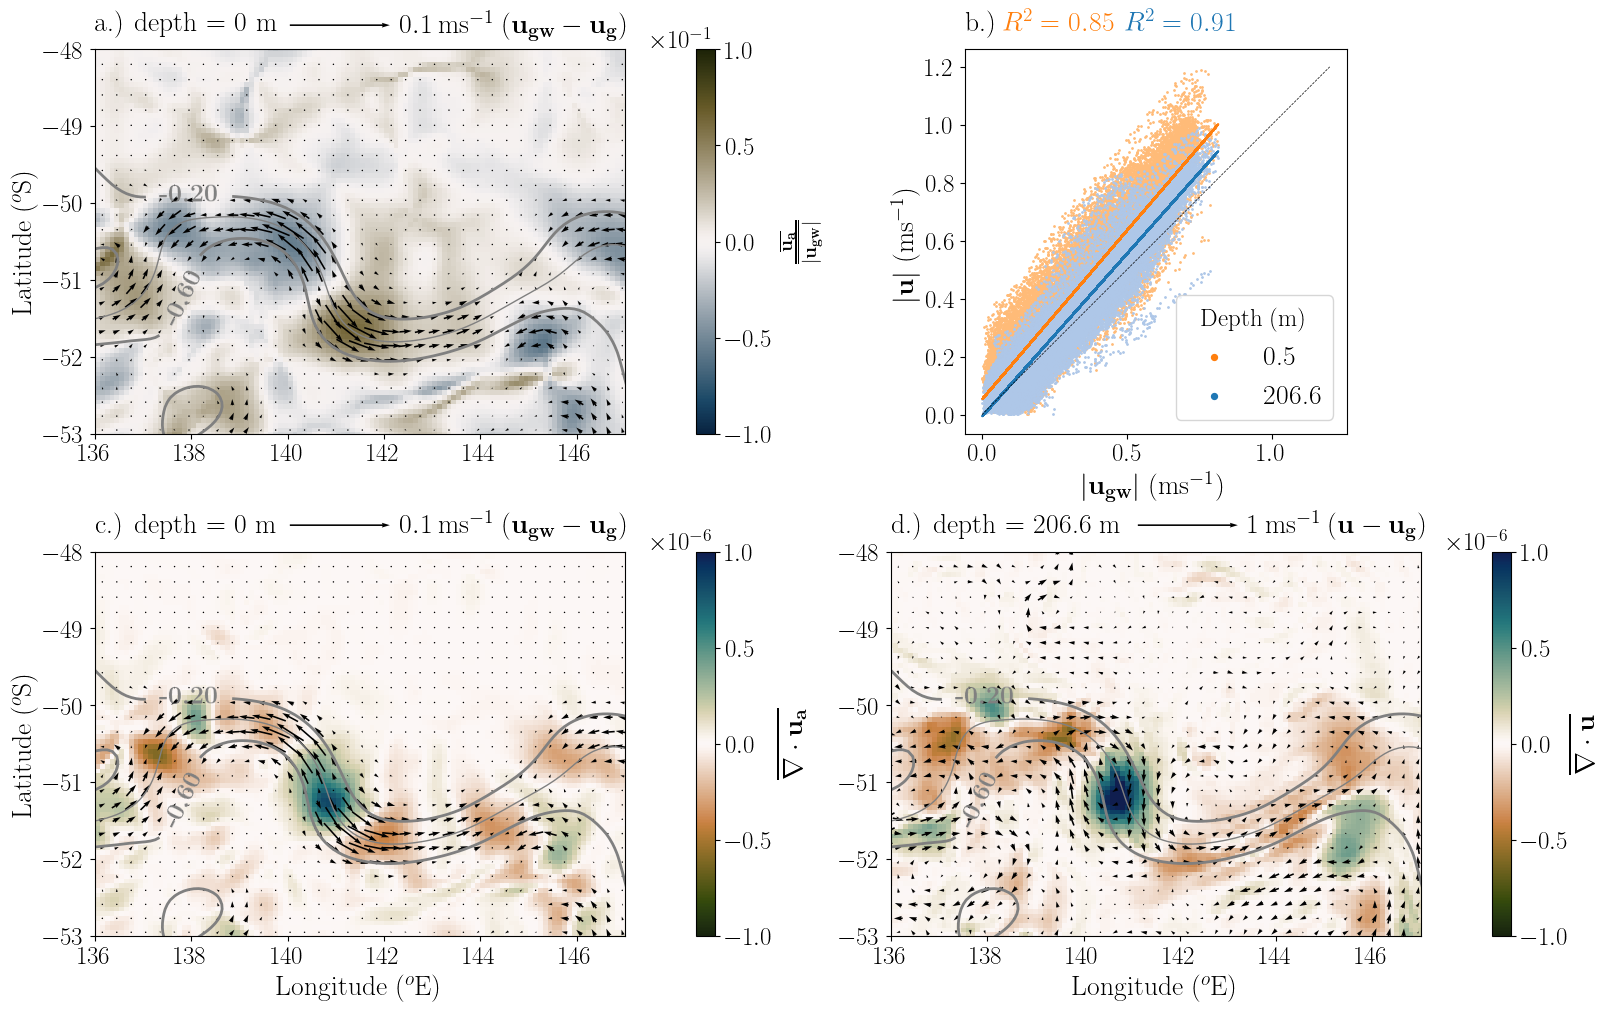

In [31]:
st_ocean_isel = 30
nrows, ncols = 2, 2
slc = xt_ocean=slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10), constrained_layout=True)

# plot Rossby number (ratio ageostrophic over gradient wind speed)
pcol = ((gw.Vgw - gw.Vg) / gw.Vgw).mean('time').plot(
    ax=ax[0, 0], cmap=cmo.cm.diff, vmin=-0.1, vmax=0.1, extend='both', add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax[0, 0])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_ylabel(r'$\frac{\overline{\bf u_a}}{\overline{|{\bf u_{gw}}|}}$', fontsize=fs_large)

quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0, 0], x='xt_ocean', y='yt_ocean', u='uag', v='vag',
    units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], add_guide=False)
qk = plt.quiverkey(quiv, 0.24, 0.98, 0.1, r'$0.1\:\mathrm{ms}^{-1}\:({\bf u_{gw} - u_g})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})

# scatter
colors = ['tab:orange', 'tab:blue']
# gw_surf = gwmean.isel(st_ocean=0).where(
#     (gwmean.sea_level > -0.6) & (gwmean.sea_level < -0.1))
gw_surf = gw.isel(st_ocean=0).where(
    (gw.sea_level > sl_contours[0]) & (gw.sea_level < sl_contours[-1]))
gw_surf.plot.scatter(
    ax=ax[0, 1], x='Vgw', y='Vtott', s=1, color=plt.cm.get_cmap('tab20').colors[3], #mcolors.to_rgba(colors[0], 0.1),
    label=np.round(gwmean.isel(st_ocean=0).st_ocean.values,1))
ax[0, 1].plot(*linear_fit(gw_surf.Vgw, gw_surf.Vtott), color=colors[0])
i=0
ax[0, 1].text(0.32*i+0.1, 1.05, r'$R^2 = %s$' %np.round(Rsquared(gw_surf.Vgw.values, gw_surf.Vtott.values)[0], 2), 
              transform=ax[0, 1].transAxes, fontsize=fs_large, color=colors[i])

# gw_mld = gwmean.isel(st_ocean=st_ocean_isel).where(
#     (gwmean.sea_level > -0.6) & (gwmean.sea_level < -0.1))
gw_mld = gw.isel(st_ocean=st_ocean_isel).where(
    (gw.sea_level > sl_contours[0]) & (gw.sea_level < sl_contours[-1]))
gw_mld.plot.scatter(
    ax=ax[0, 1], x='Vgw', y='Vtott', s=1, color=plt.cm.get_cmap('tab20').colors[1], 
    label=np.round(gwmean.isel(st_ocean=st_ocean_isel).st_ocean.values,1))
ax[0, 1].plot(*linear_fit(gw_mld.Vgw, gw_mld.Vtott), color=colors[1])
i=1
ax[0, 1].text(0.32*i+0.1, 1.05, r'$R^2 = %s$' %np.round(Rsquared(gw_mld.Vgw.values, gw_mld.Vtott.values)[0], 2), 
              transform=ax[0, 1].transAxes, fontsize=fs_large, color=colors[i])

x= np.linspace(0, 1.2)
ax[0, 1].plot(x, x, '--', color='k', lw=0.5)
lgnd = ax[0, 1].legend(loc="lower right", fontsize=fs_large, title='Depth (m)')
for i, handle in enumerate(lgnd.legendHandles):
    handle.set_sizes([fs_small])
    handle.set_color(colors[i])
lgnd.get_title().set_fontsize(fs_small) #legend 'Title' fontsize
plt.setp(ax[0, 1].get_legend().get_texts(), fontsize=fs_large)

ax[0, 1].set_title(r'')
ax[0, 1].set_xlabel(r'$|{\bf u_{gw}}|$ (ms$^{-1}$)', fontsize=fs_large)
ax[0, 1].set_ylabel(r'$|{\bf u}|$ (ms$^{-1}$)', fontsize=fs_large)
ax[0, 1].set_aspect('equal')

# hor. divergence from gradient wind velocities
pcol = div_u_gw.sel(time=flex_period).mean('time').plot(ax=ax[1, 0],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax[1, 0])
cbar.ax.set_ylabel(r'$\overline{\bf \nabla \cdot u_a}$', fontsize=fs_large)

quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1, 0], x='xt_ocean', y='yt_ocean', u='uag', v='vag', 
    units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], add_guide=False)
qk = plt.quiverkey(quiv, 0.24, 0.48, 0.1, r'$0.1\:\mathrm{ms}^{-1}\:({\bf u_{gw} - u_g})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})

# hor. divergence from total velocities
pcol = div_u.sel(time=flex_period).mean('time').isel(st_ocean=st_ocean_isel).plot(ax=ax[1, 1],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax[1, 1])
cbar.ax.set_ylabel(r'$\overline{\bf \nabla \cdot u}$', fontsize=fs_large)

quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1, 1], x='xt_ocean', y='yt_ocean', u='dug', v='dvg', 
    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], add_guide=False)
qk = plt.quiverkey(quiv, 0.77, 0.48, 1, r'$1\:\mathrm{ms}^{-1}\:({\bf u - u_{g}})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})
ax[1, 1].set_title(r'')


for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    if (r, c) == (1, 1):
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + '.) depth = %s m' %np.round(div_u.isel(st_ocean=st_ocean_isel).st_ocean.values,1), 
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
    elif (r, c) == (0, 1):
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + '.)', 
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
    else:
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + '.) depth = 0 m', 
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
        
    if (r, c) != (0, 1):
        cont = gw.sea_level.mean('time').plot.contour(
            ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')

        for ib, b in enumerate(sl_contours):
            if b in sl_contours[::2]:
                zc = cont.collections[ib]
                plt.setp(zc, linewidth=2)
        ax[r, c].clabel(cont, sl_contours[::2], inline=1, fmt=r'{\bf %.2f}', fontsize=fs_small)

        ax[r, c].set_xlabel(r'Longitude ($^o$E)', fontsize=fs_large)
        ax[r, c].set_ylabel(r'Latitude ($^o$S)', fontsize=fs_large)
        ax[r, c].set_xlim([136, 147])
        ax[r, c].set_ylim([-53, -48])

ax[0, 0].set_xlabel('')
ax[1, 1].set_ylabel('')

In [32]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '03_validation-gradient-wind' + extension), 
                    transparent=transparent, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [33]:
gw_core = ds_gw.where((ds_gw.sea_level > sl_contours[0]) & (ds_gw.sea_level < sl_contours[-1]))
gw_core = gw_core.sel(xt_ocean=slice(137,147), yt_ocean=slice(-53, -48))

# gw_core.divu.sel(st_ocean=200, method='nearest').plot(cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6)

Text(0, 0.5, '')

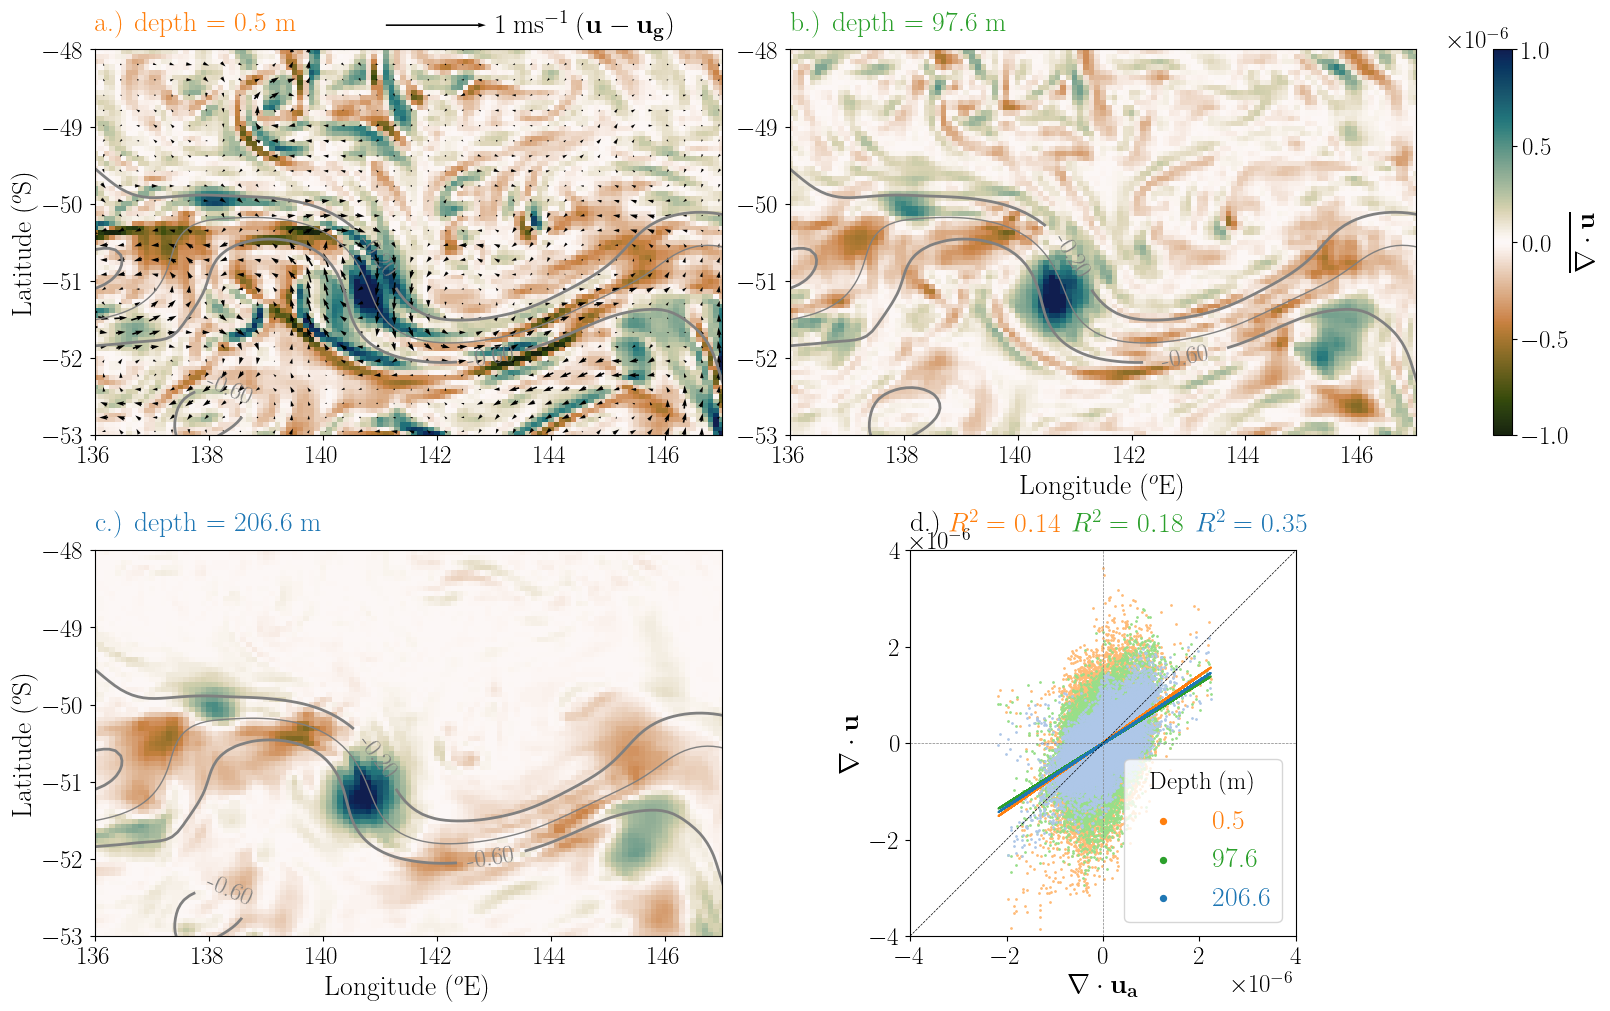

In [34]:
st_ocean_sel = [0, 100, 200]
nrows, ncols = 2, 2
slc = xt_ocean=slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10), constrained_layout=True)

# hor. divergence at 0m depth
pcol = div_u.sel(time=flex_period).mean('time').sel(st_ocean=st_ocean_sel[0], method='nearest').plot(ax=ax[0, 0],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)

quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0, 0], x='xt_ocean', y='yt_ocean', u='dug', v='dvg', 
    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], add_guide=False)

# hor. divergence at 30m depth
pcol = div_u.sel(time=flex_period).mean('time').sel(st_ocean=st_ocean_sel[1], method='nearest').plot(ax=ax[0, 1],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)

# quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
#     ax=ax[0, 1], x='xt_ocean', y='yt_ocean', u='dug', v='dvg', 
#     units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], add_guide=False)

# hor. divergence at 100m depth
pcol = div_u.sel(time=flex_period).mean('time').sel(st_ocean=st_ocean_sel[2], method='nearest').plot(ax=ax[1, 0],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)

# colorbar and quiver key
cbar = fig.colorbar(pcol, ax=ax[0, 1])
cbar.ax.set_ylabel(r'$\overline{\bf \nabla \cdot u}$', fontsize=fs_large)
qk = plt.quiverkey(quiv, 0.3, 0.98, 1, r'$1\:\mathrm{ms}^{-1}\:({\bf u - u_{g}})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large}, transform=ax[0, 0].transAxes)

# scatter
lim = 4e-6
lightcolors = [plt.cm.get_cmap('tab20').colors[3], plt.cm.get_cmap('tab20').colors[5], plt.cm.get_cmap('tab20').colors[1]]
colors = ['tab:orange', 'tab:green', 'tab:blue']
for i, depth in enumerate(st_ocean_sel):
    # sel = ds_gw.sel(xt_ocean=slice(137,147), yt_ocean=slice(-53, -48)).sel(st_ocean=depth, method='nearest')
    sel = gw_core.sel(st_ocean=depth, method='nearest')
    sel.plot.scatter(ax=ax[1, 1], x='divua', y='divu', s=1, color=lightcolors[i], label=np.round(sel.st_ocean.values,1), zorder=-1+i)
    ax[1, 1].plot(*linear_fit(sel.divua, sel.divu), color=colors[i])
    if i == 0:
        ax[1, 1].text(0, 1.05, string.ascii_lowercase[iax] + '.)', 
                      transform=ax[1, 1].transAxes, size=fs_large)
    ax[1, 1].text(0.32*i+0.1, 1.05, r'$R^2 = %s$' %np.round(Rsquared(sel.divua.values, sel.divu.values)[0], 2), 
                  transform=ax[1, 1].transAxes, fontsize=fs_large, color=colors[i])
    ax[1, 1].set_xlabel(r'$\bf \nabla \cdot u_a$', fontsize=fs_large)
    ax[1, 1].set_ylabel(r'$\bf \nabla \cdot u$', fontsize=fs_large)


x = np.linspace(-lim, lim)
ax[1, 1].axhline(y=0, linestyle='--', color='gray', lw=0.5)
ax[1, 1].axvline(x=0, linestyle='--', color='gray', lw=0.5)
ax[1, 1].plot(x, x, '--', color='k', lw=0.5)
# ax[1, 1].set_xlim([-2.5e-6, 2.5e-6])
ax[1, 1].set_xlim([-lim, lim])
ax[1, 1].set_ylim([-lim, lim])
ax[1, 1].set_aspect('equal')
ax[1, 1].set_title('')

lgnd = ax[1, 1].legend(loc="lower right", fontsize=fs_large, title='Depth (m)')
for i, handle in enumerate(lgnd.legendHandles):
    handle.set_sizes([fs_small])
    handle.set_color(colors[i])
for i, text in enumerate(lgnd.texts):
    text.set_color(colors[i])
lgnd.get_title().set_fontsize(fs_small)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols    

    if (r, c) != (1, 1):
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + 
                      '.) depth = %s m' %np.round(div_u.sel(st_ocean=st_ocean_sel[iax], method='nearest').st_ocean.values,1), 
                      transform=ax[r, c].transAxes, size=fs_large, color=colors[iax])
            
        cont = ds_gw.sea_level.mean('time').plot.contour(
            ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')

        for ib, b in enumerate(sl_contours):
            if b in sl_contours[::2]:
                zc = cont.collections[ib]
                plt.setp(zc, linewidth=2)
        ax[r, c].clabel(cont, sl_contours[::2], inline=1, fmt='%.2f', fontsize=fs_small)

        ax[r, c].set_xlabel(r'Longitude ($^o$E)', fontsize=fs_large)
        ax[r, c].set_ylabel(r'Latitude ($^o$S)', fontsize=fs_large)
        ax[r, c].set_xlim([136, 147])
        ax[r, c].set_ylim([-53, -48])
        

ax[0, 0].set_xlabel('')
ax[0, 1].set_ylabel('')


In [35]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, 'B1_validation-hor-divergence' + extension), 
                    transparent=transparent, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


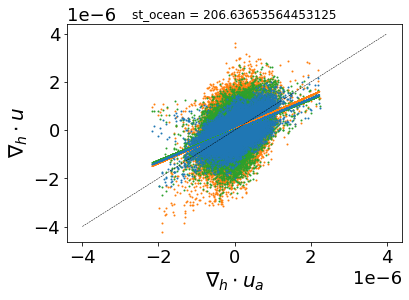

In [31]:
colors = ['tab:orange', 'tab:green', 'tab:blue']
for i, d in enumerate([0, 100, 500]):
    sel = gw_core.sel(st_ocean=d, method='nearest')
    sel.plot.scatter(x='divua', y='divu', s=1, color=colors[i])
    plt.plot(*linear_fit(sel.divua, sel.divu), color=colors[i])
x=np.linspace(-4e-6, 4e-6)
plt.plot(x, x, '--', color='k', lw=0.5)


0.3157781531420565


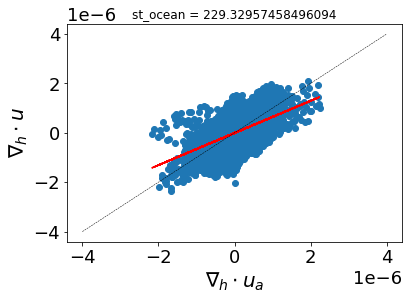

In [43]:
d = 230
sel = gw_core.sel(st_ocean=d, method='nearest')
sel.plot.scatter(x='divua', y='divu')
plt.plot(*linear_fit(sel.divua, sel.divu), color='r')
x=np.linspace(-4e-6, 4e-6)
plt.plot(x, x, '--', color='k', lw=0.5)
print(Rsquared(sel.divua.values, sel.divu.values)[0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

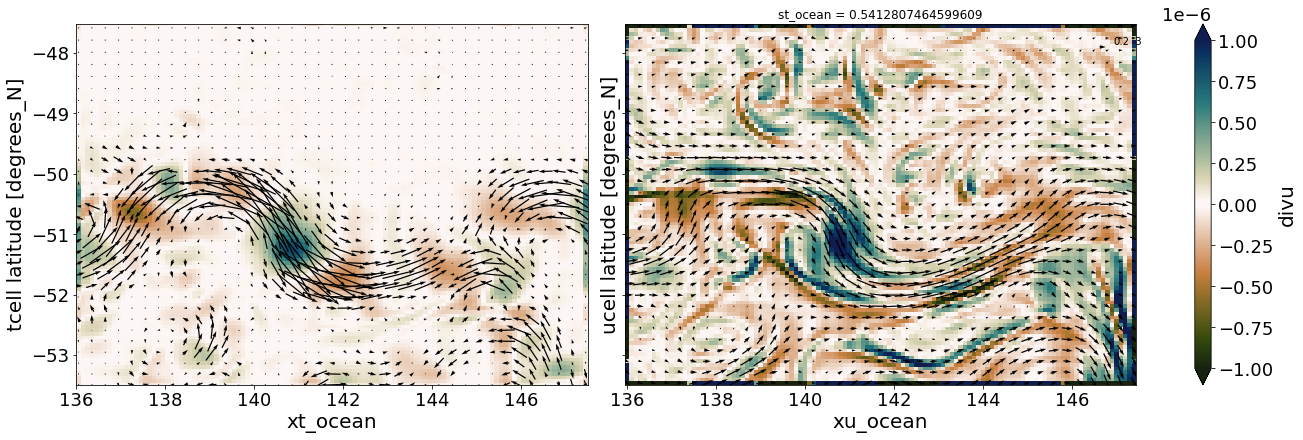

In [23]:
nrows, ncols = 1, 2
slc = slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,6), 
                       sharey=True, constrained_layout=True)

slc = slice(None, None, 3)
div_u_gw.sel(time=flex_period).mean('time').plot(ax=ax[0],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0], x='xt_ocean', y='yt_ocean', u='uag', v='vag')

div_u.sel(time=flex_period).mean('time').isel(st_ocean=0).plot(ax=ax[1],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6)
ds.sel(time=flex_period, xu_ocean=slc, yu_ocean=slc).mean('time').sel(st_ocean=0, method='nearest').plot.quiver(
    x='xu_ocean', y='yu_ocean', u='u', v='v')

# hor. divergence from total velocities
pcol = div_u.sel(time=flex_period).mean('time').isel(st_ocean=st_ocean_isel).plot(ax=ax[1, 1],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax[1, 1])
cbar.ax.set_ylabel(r'$\overline{\bf \nabla \cdot u}$', fontsize=fs_large)


for iax in range(len(ax)):
    cont = gw.sea_level.mean('time').plot.contour(
        ax=ax[iax], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')
    
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[0::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=2)
    ax[iax].clabel(cont, sl_contours[0::2], inline=1, fmt='%.2f')
    
    ax[iax].set_xlabel(r'Longitude ($^o$E)', fontsize=fs_large)
    ax[iax].set_ylabel(r'Latitude ($^o$S)', fontsize=fs_large)
ax[1].set_ylabel('')

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

In [22]:
fig, ax = plt.subplots()

# hor. divergence from total velocities
pcol = div_u.sel(time=flex_period).mean('time').isel(st_ocean=0).plot(ax=ax,
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax)
cbar.ax.set_ylabel(r'${\bf \nabla \cdot u}$', fontsize=fs_large)

quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax, x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', 
    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], add_guide=False)
qk = plt.quiverkey(quiv, 0.76, 0.48, 1, r'$1\:\mathrm{ms}^{-1}\:({\bf u - u_{gw}})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})

RuntimeError: latex was not able to process the following string:
b'tcell longitude [degrees_E]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/581/jm6603/.cache/matplotlib/tex.cache/1f5fbeb57321c4571becdd0d306dd418.
tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amssymb.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 1f5fbeb57321c4571becdd0d306dd418.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.21 {\rmfamily tcell longitude [degrees_
                                         E]}
No pages of output.
Transcript written on 1f5fbeb57321c4571becdd0d306dd418.log.




<Figure size 432x288 with 2 Axes>

## Normal and shear strain

In [23]:
plt.rcParams.update(plt.rcParamsDefault)

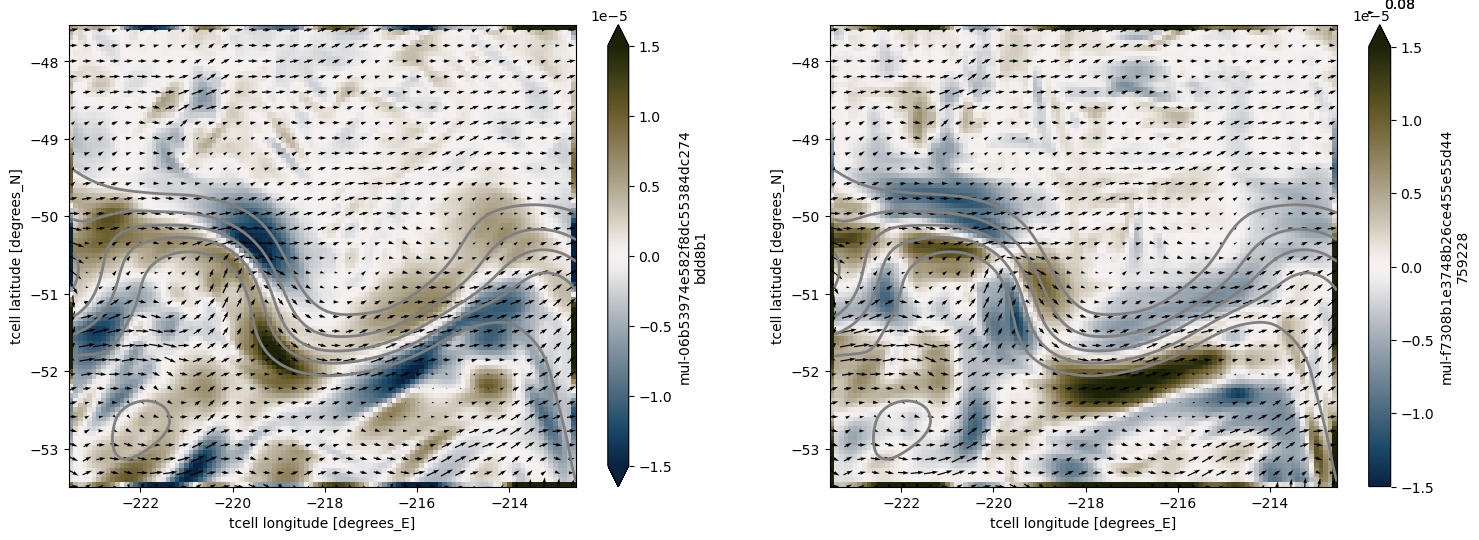

In [24]:
sn, ss, sigma = horizontal_strain(ds, grid)
zeta = relative_vorticity(ds, grid)

fig, ax = plt.subplots(figsize=(18,6), ncols=2)
slc = slice(None, None, 3)

sn.sel(time=flex_period).mean('time').sel(st_ocean=0, method='nearest').plot(ax=ax[0],
    cmap=cmo.cm.diff, vmin=-1.5e-5, vmax=1.5e-5)
ss.sel(time=flex_period).mean('time').sel(st_ocean=0, method='nearest').plot(ax=ax[1],
    cmap=cmo.cm.diff, vmin=-1.5e-5, vmax=1.5e-5)

sl_contours = np.linspace(-0.6, -0.1, 5)
for iax in range(ax.size):
    gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
        ax=ax[iax], x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', color='k')
#     ds.sel(time=flex_period, xu_ocean=slc, yu_ocean=slc).mean('time').sel(st_ocean=0, method='nearest').plot.quiver(
#         ax=ax[iax], x='xu_ocean', y='yu_ocean', u='u', v='v')
    cont = ds.sea_level.mean('time').plot.contour(
            ax=ax[iax], levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')

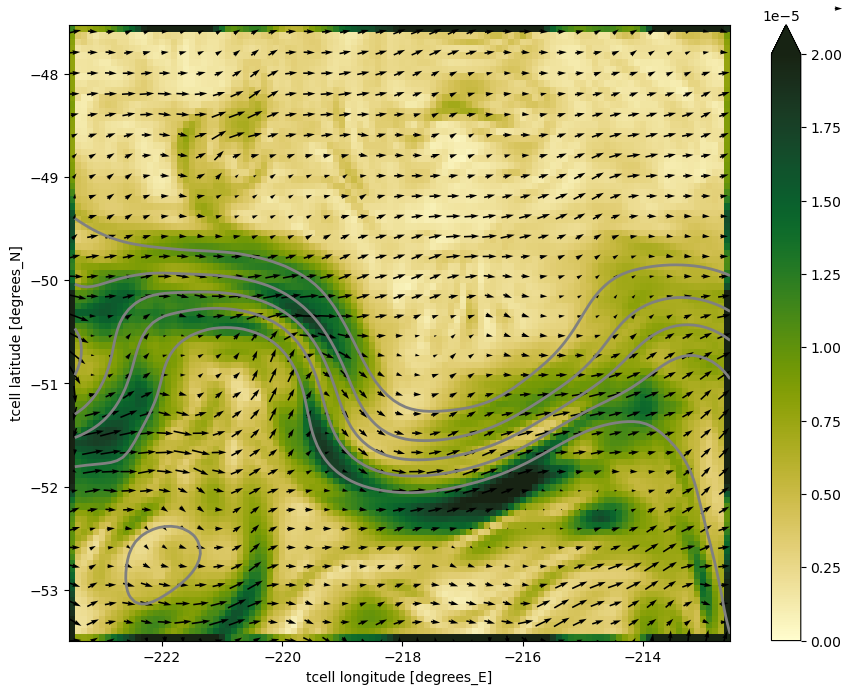

In [25]:
sigma.sel(time=flex_period).mean('time').sel(st_ocean=0, method='nearest').plot(
    size=8, cmap=cmo.cm.speed, vmin=0, vmax=2e-5)
gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', color='k')
cont = ds.sea_level.mean('time').plot.contour(
    levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')



### Okubo-Weiss parameter

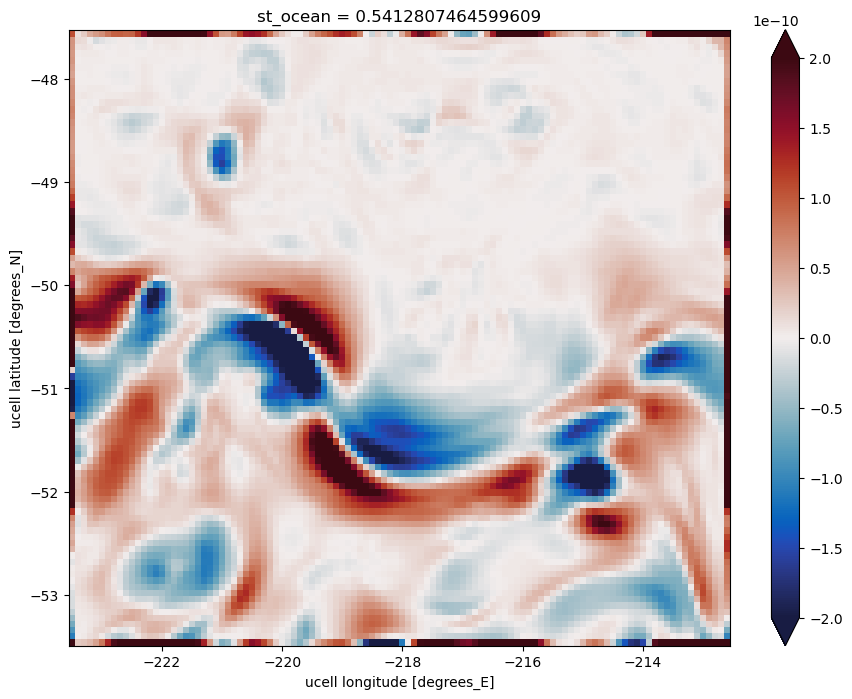

In [26]:
(sn**2 + ss**2 - zeta**2).sel(time=flex_period).mean('time').sel(st_ocean=0, method='nearest').plot(
    size=8, cmap=cmo.cm.balance, vmin=-2e-10, vmax=2e-10)

## Joint Probability Density Function

In [27]:
from gsw import f
fu = np.broadcast_to(f(gw.yu_ocean).values[np.newaxis].T, gw.utot.shape[1:])
ft = np.broadcast_to(f(gw.yt_ocean).values[np.newaxis].T, gw.utott.shape[1:])